__Note:__
- Following notebook uses the oxford pets dataset which can be downloaded from https://www.robots.ox.ac.uk/~vgg/data/pets/
- This notebook uses timm for trying resnet 50,
- Training is done with mixed precision
- This notebook uses albumentation instead of kornia for augmentations

REFERENCES: 

1. https://github.com/rwightman/pytorch-image-models
2. https://pytorch.org/vision/stable/models.html
3. https://pytorch.org/hub/
4. https://albumentations.ai/

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from torch import optim
from torchsummary import summary
from torchvision import models, transforms
import random
from tqdm import tqdm

# For file and directory related operation
import os
import pathlib
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting Seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)  
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True

# Hyperparameters

In [2]:
# mean and std-dev taken from imagenet dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
in_channels = 3
batch_size = 64
valid_size = 0.2
resize_side = 360
output_image_crop = (224, 224)
dropout_p = 0.2
img_aug_p = 0.5
learning_rate = 1e-04
epochs = 10

# Loading Data

In [3]:
base_path = pathlib.Path('./data/pets_dataset/images')
all_images = list(base_path.glob('./*.jpg'))
all_images[:10]

[PosixPath('data/pets_dataset/images/american_bulldog_143.jpg'),
 PosixPath('data/pets_dataset/images/yorkshire_terrier_176.jpg'),
 PosixPath('data/pets_dataset/images/pomeranian_98.jpg'),
 PosixPath('data/pets_dataset/images/yorkshire_terrier_1.jpg'),
 PosixPath('data/pets_dataset/images/Siamese_168.jpg'),
 PosixPath('data/pets_dataset/images/english_setter_86.jpg'),
 PosixPath('data/pets_dataset/images/keeshond_36.jpg'),
 PosixPath('data/pets_dataset/images/staffordshire_bull_terrier_19.jpg'),
 PosixPath('data/pets_dataset/images/Ragdoll_130.jpg'),
 PosixPath('data/pets_dataset/images/chihuahua_195.jpg')]

It is evident and also mentioned on the website of the dataset that the label of the image is in the file.

In [4]:
def get_label(fname):
    # Get filename without extension
    class_name = fname.stem
    # Remove the number from the file name
    class_ = class_name[:class_name.rfind('_')]
    return class_
print(all_images[0])
get_label(all_images[0])

data/pets_dataset/images/american_bulldog_143.jpg


'american_bulldog'

In [5]:
def clean_data(all_images):
    # Cleaning Data
    count = 0
    for img_path in tqdm(all_images):
        # Reading Error
        try:
            img = plt.imread(img_path)
        except:
            os.remove(img_path)
            count += 1
            continue
        # Grayscale image or has an alpha channel
        if len(img.shape) != 3 or img.shape[2] != 3:
            os.remove(img_path)
            count+=1
    print(f"Removed {count} images")
# clean_data(all_images)

In [6]:
unique_labels = list(set([get_label(fname) for fname in all_images]))
label_to_idx = {category:idx for idx, category in enumerate(unique_labels)}
print(f"Dataset Consists of {len(all_images)} images and {len(unique_labels)} categories")

Dataset Consists of 7378 images and 37 categories


In [7]:
# Random split
random.shuffle(all_images)
valid_final_idx = int(valid_size * len(all_images))
valid_images = all_images[:valid_final_idx]
train_images = all_images[valid_final_idx:]
print(f"No of Training Examples: {len(train_images)} and No of Validation Examples: {len(valid_images)}")

No of Training Examples: 5903 and No of Validation Examples: 1475


In [8]:
class PetsDataset(Dataset):
    def __init__(self, images_path, all_categories, label_to_idx, augment):
        self.images_path = images_path
        self.all_categories = all_categories
        self.label_to_idx = label_to_idx
        self.augment = augment
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        img_name = self.images_path[idx]
        lbl = self.get_label(img_name)
        lbl = torch.tensor(lbl)
        img = plt.imread(img_name) / 255.
        final_img = self.augment(image=img)['image']
        return final_img, lbl
    
    def get_label(self, fname):
        class_name = fname.stem
        label = self.label_to_idx[class_name[:class_name.rfind('_')]]
        return label

In [9]:
train_augmentation = A.Compose([A.LongestMaxSize(max_size=resize_side, interpolation=1),
                                 A.PadIfNeeded(min_height=resize_side, min_width=resize_side, border_mode=0, value=(0,0,0)),
                                 A.ShiftScaleRotate(shift_limit=(0.1,0.1), scale_limit=0.1, rotate_limit=30, p=img_aug_p),
                                 A.CenterCrop(height = output_image_crop[0], width = output_image_crop[1]),
                                 A.HorizontalFlip(p=img_aug_p),
                                 A.Normalize(mean, std, max_pixel_value=1.0),
                                 ToTensorV2(),
                                 ])
train_dataset = PetsDataset(all_images, unique_labels, label_to_idx, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 8, pin_memory = True, shuffle = True)

In [10]:
imgs, lbls = next(iter(trainloader))

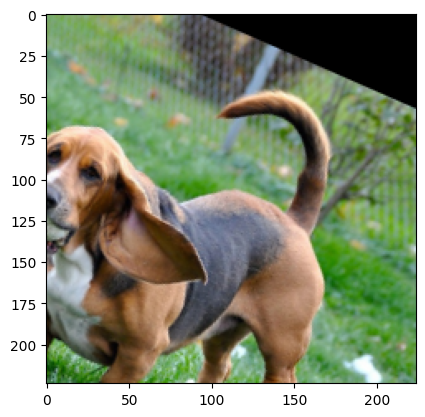

In [11]:
denormalization = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                      transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                         std = [ 1., 1., 1. ])])
idx = 0
denormalized_img = np.transpose(denormalization(imgs[idx]).numpy(), (1,2,0))
plt.imshow(denormalized_img);

In [12]:
model = timm.create_model('resnet50', pretrained = True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

For transfer learning fully connected (fc) classifier has to be replaced with our own fc classifier and some layers has to be frozen (earlier layers specifically so as not to update earlier layers weight)

In [13]:
def get_data(aug_p = 0.5, bs = 64):
    train_augmentation = A.Compose([A.LongestMaxSize(max_size=resize_side, interpolation=1),
                                 A.PadIfNeeded(min_height=resize_side, min_width=resize_side, border_mode=0, value=(0,0,0)),
                                 A.ShiftScaleRotate(shift_limit=(0.1,0.1), scale_limit=0.1, rotate_limit=30, p=img_aug_p),
                                 A.CenterCrop(height = output_image_crop[0], width = output_image_crop[1]),
                                 A.HorizontalFlip(p=img_aug_p),
                                 A.Normalize(mean, std, max_pixel_value=1.0),
                                 ToTensorV2(),
                                 ])
    train_dataset = PetsDataset(train_images, unique_labels, label_to_idx, train_augmentation)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 8, pin_memory = True, shuffle = True)
    
    valid_augmentation = A.Compose([A.LongestMaxSize(max_size=resize_side, interpolation=1),
                                 A.PadIfNeeded(min_height=resize_side, min_width=resize_side, border_mode=0, value=(0,0,0)),
                                 A.CenterCrop(height = output_image_crop[0], width = output_image_crop[1]),
                                 A.Normalize(mean, std, max_pixel_value=1.0),
                                 ToTensorV2(),
                                 ])
    valid_dataset = PetsDataset(valid_images, unique_labels, label_to_idx, valid_augmentation)
    validloader = DataLoader(valid_dataset, batch_size = batch_size, num_workers = 8, pin_memory = True, shuffle = True)
    return trainloader, validloader

def save_checkpoint(model):
    torch.save(model.state_dict(), './saved_models/checkpoint.pt')
    
def load_checkpoint(model):
    model.load_state_dict(torch.load('./saved_models/checkpoint.pt'))
    return model
    
def get_model(dropout_prob, freeze = True, num_freeze = 29):
    model = timm.create_model('resnet50', pretrained = True)
    lin_features = model.num_features
    layers = list(model.children())[:-1] # Removed Top Classifier layer
    layers.extend([nn.Linear(in_features=lin_features, out_features = 512),
                   nn.ReLU(),
                   nn.Dropout(dropout_prob),
                   nn.Linear(512, 37)]) # Number of output categories is 37
    model = nn.Sequential(*layers)
    if freeze:
        for idx, param in enumerate(model.parameters()):
            if idx <= num_freeze:
                param.requires_grad = False        
        print(f"Total Number of Layers: {idx} and Number of Frozen Layer: {num_freeze}")
    else:
        print("None of the layer is frozen")
    return model

def build_model(model, lr = 1e-03):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    return optimizer, criterion

def no_of_correct(imgs, lbls, model):
    imgs, lbls, model = imgs.to(device, non_blocking = True), lbls.to(device, non_blocking = True), model.to(device)
    with torch.no_grad():
        model.eval()
        out = model(imgs)
        _, preds= out.max(-1)
        correct_preds = preds == lbls
        return correct_preds.cpu().numpy().sum(), len(lbls)

In [14]:
model = get_model(dropout_p, freeze = True, num_freeze = 150) # Set freeze = False to not freeze any layer
summary(model, torch.rand(32, 3, 224, 224));

Total Number of Layers: 162 and Number of Frozen Layer: 150
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─Identity: 3-6                [-1, 64, 56, 56]          --


In [15]:
def train_batch(imgs, lbls, model, criterion, optimizer, scaler, valid = False):
    optimizer.zero_grad()
    imgs, lbls, model = imgs.to(device, non_blocking = True), lbls.to(device, non_blocking = True), model.to(device)
    with torch.cuda.amp.autocast():
        out = model(imgs)
        batch_loss = criterion(out, lbls)
    if not valid:
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return batch_loss.item()

def train(load_check = False, freeze = True, frozen_layer = 150, best_valid_metric = 0.0, batch_size = 32):    
    trainloader, validloader = get_data(img_aug_p, batch_size)
    model = get_model(dropout_p, freeze = freeze, num_freeze = frozen_layer)
    
    # Load From checkpoing
    if load_check:
        model = load_checkpoint(model)
        
    optimizer, criterion = build_model(model, lr = learning_rate)
    scaler = torch.cuda.amp.GradScaler()
    train_accuracies, valid_accuracies = [], []
    train_losses, valid_losses = [], []
    for epoch in range(epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, lbls in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, lbls, model, criterion, optimizer, scaler)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        total_correct = 0
        total = 0
        for imgs, lbls in trainloader:
            imgs = imgs.to(torch.float32)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total

        epoch_train_acc = total_correct/total
        train_accuracies.append(epoch_train_acc)
        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        total_correct = 0
        total = 0
        for imgs, lbls in validloader:
            imgs = imgs.to(torch.float32)
            batch_loss += train_batch(imgs, lbls, model, criterion, optimizer, scaler, valid = True)
            batch_correct, batch_total = no_of_correct(imgs, lbls, model)
            total_correct += batch_correct
            total += batch_total


        epoch_valid_loss = batch_loss / len(validloader)
        epoch_valid_acc = total_correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)
        
        # Checkpoint
        if epoch_valid_acc >= best_valid_metric:
            print('#### Saving ####')
            save_checkpoint(model)
            best_valid_metric = epoch_valid_acc
            

        print(f"{'*'*10} EPOCH {epoch:2}/{epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}, Train Accuracy: {epoch_train_acc*100:5.2f}
Valid Loss: {epoch_valid_loss:5.3f}, Valid Accuracy: {epoch_valid_acc*100:5.2f}
{"#"*33}''')
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, best_valid_metric

In [ ]:
model, train_losses, train_accuracies, valid_losses, \
        valid_accuracies, best_valid_metric = train(freeze = True, batch_size=batch_size)

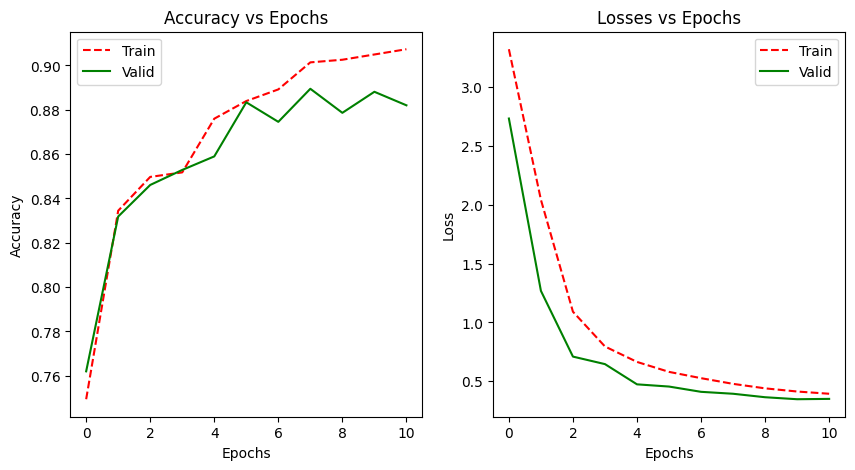

In [17]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

In [ ]:
learning_rate = 3e-06
dropout_p = 0.5
batch_size = 32
model, train_losses, train_accuracies, valid_losses, \
valid_accuracies, best_valid_metric = train(load_check=True, freeze = False,
                                            best_valid_metric = best_valid_metric, batch_size = batch_size)

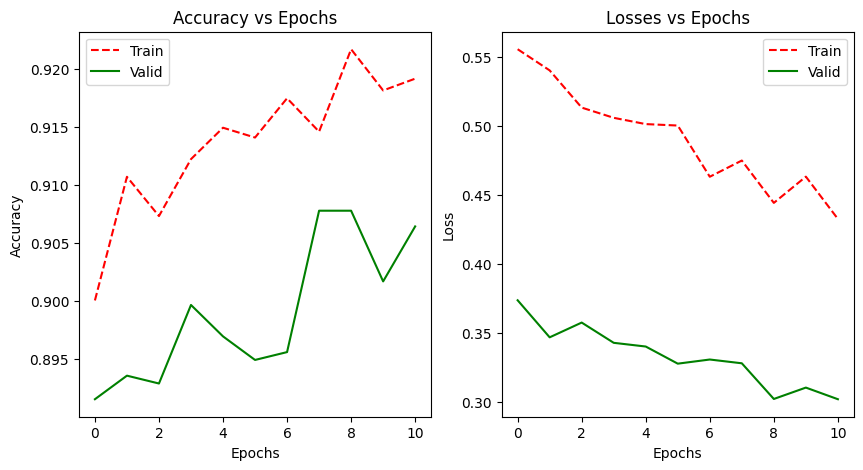

In [19]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

Achieving almost 90% accuracy on valid set and 93 on train set better than VGG

None of the layer is frozen


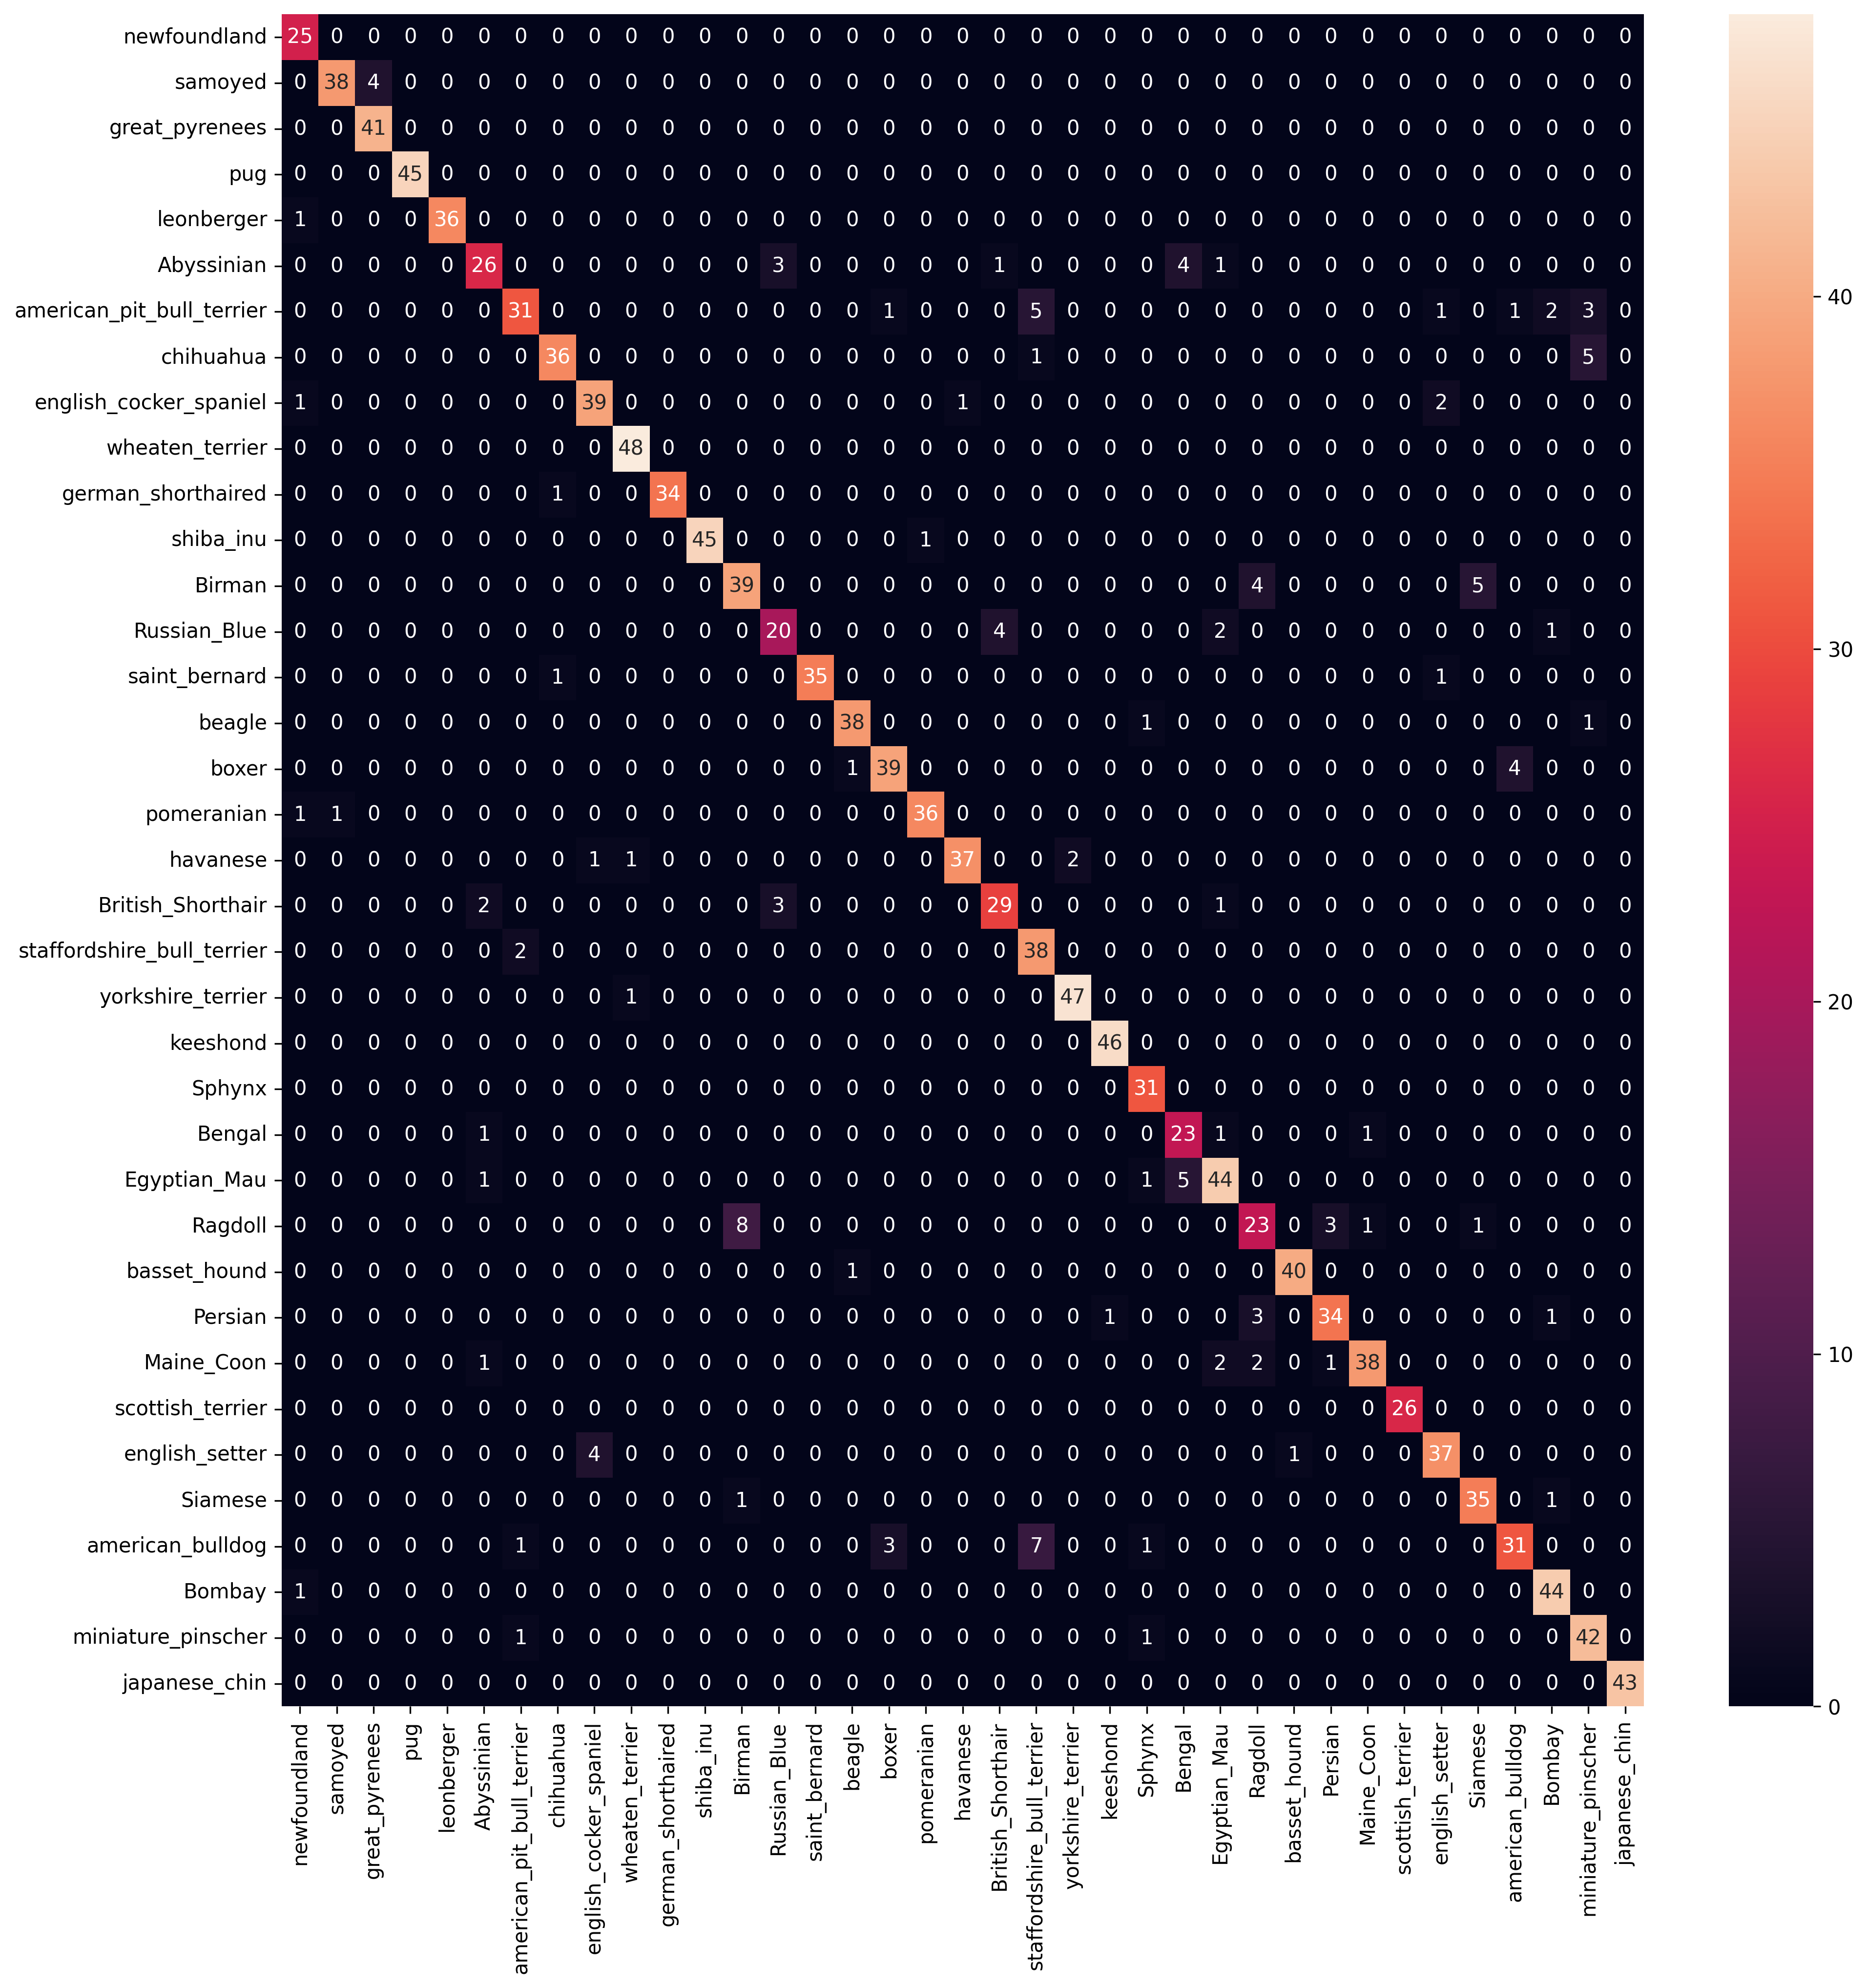

In [20]:
# Implementing confusion matrix for valid dataset
def plot_confusion_matrix(dataloader, model, fig_size = (10,10)):
    with torch.no_grad():
        model.eval()
        model = model.to(device)
        y_preds, y_true = [], []
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device, non_blocking = True), lbls.to(device, non_blocking = True)
            out = model(imgs)
            _, preds = out.max(-1)
            y_preds.extend(preds.cpu().numpy().tolist())
            y_true.extend(lbls.cpu().numpy().tolist())
        conf_mat = confusion_matrix(y_true, y_preds, labels = list(range(len(unique_labels))))
        df_conf_mat = pd.DataFrame(conf_mat, index = unique_labels, columns = unique_labels)
        plt.figure(figsize = fig_size, dpi=300)
        sns.heatmap(df_conf_mat, annot = True)
        plt.show();

model = get_model(dropout_p, freeze = False)
model = load_checkpoint(model)
_, validloader = get_data(img_aug_p, batch_size)
plot_confusion_matrix(validloader, model, fig_size = (15,15))

# Training model with batch norm in linear layers

In [21]:
def get_model(dropout_prob, freeze = True, num_freeze = 29):
    model = timm.create_model('resnet50', pretrained = True)
    lin_features = model.num_features
    layers = list(model.children())[:-1] # Removed Top Classifier layer
    layers.extend([nn.Linear(in_features=lin_features, out_features = 512),
                   nn.ReLU(),
                   nn.BatchNorm1d(512),
                   nn.Dropout(dropout_prob),
                   nn.Linear(512, 37)]) # Number of output categories is 37
    model = nn.Sequential(*layers)
    if freeze:
        for idx, param in enumerate(model.parameters()):
            if idx <= num_freeze:
                param.requires_grad = False        
        print(f"Total Number of Layers: {idx} and Number of Frozen Layer: {num_freeze}")
    else:
        print("None of the layer is frozen")
    return model

In [ ]:
dropout_p = 0.2
learning_rate = 1e-04
model, train_losses, train_accuracies, valid_losses, \
        valid_accuracies, best_valid_metric = train(freeze = True, batch_size=batch_size)

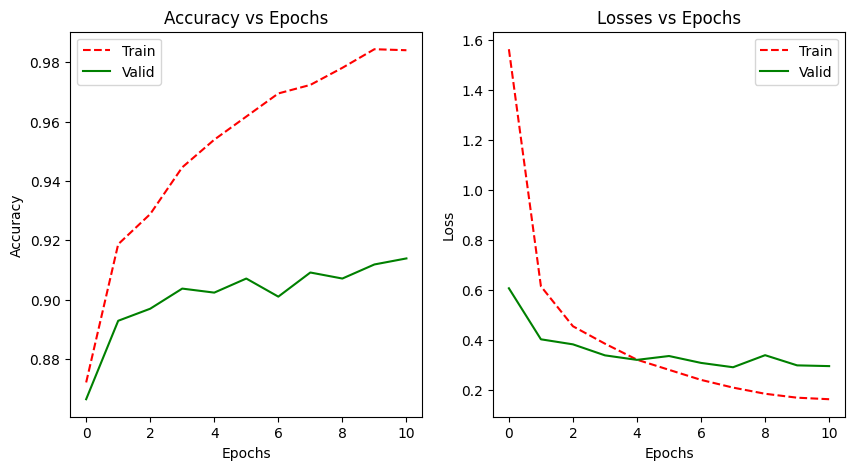

In [24]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

Untrained model with batch norm performed better than the untrained model without batchnorm. Adding a single batch norm layers improved model performance in this particular dataset. Now let's unfreeze the model and increase dropout probability to counter overfitting

In [ ]:
learning_rate = 3e-06
dropout_p = 0.5
batch_size = 32
model, train_losses, train_accuracies, valid_losses, \
valid_accuracies, best_valid_metric = train(load_check=True, freeze = False,
                                            best_valid_metric = best_valid_metric, batch_size = batch_size)

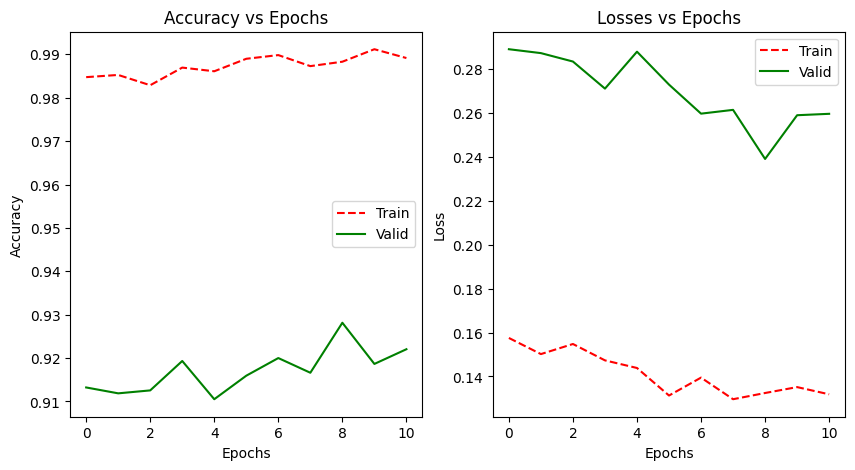

In [26]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, 'r--', label = 'Train')
plt.plot(valid_accuracies, 'g-', label = 'Valid')
plt.legend()
plt.subplot(122)
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend();

None of the layer is frozen


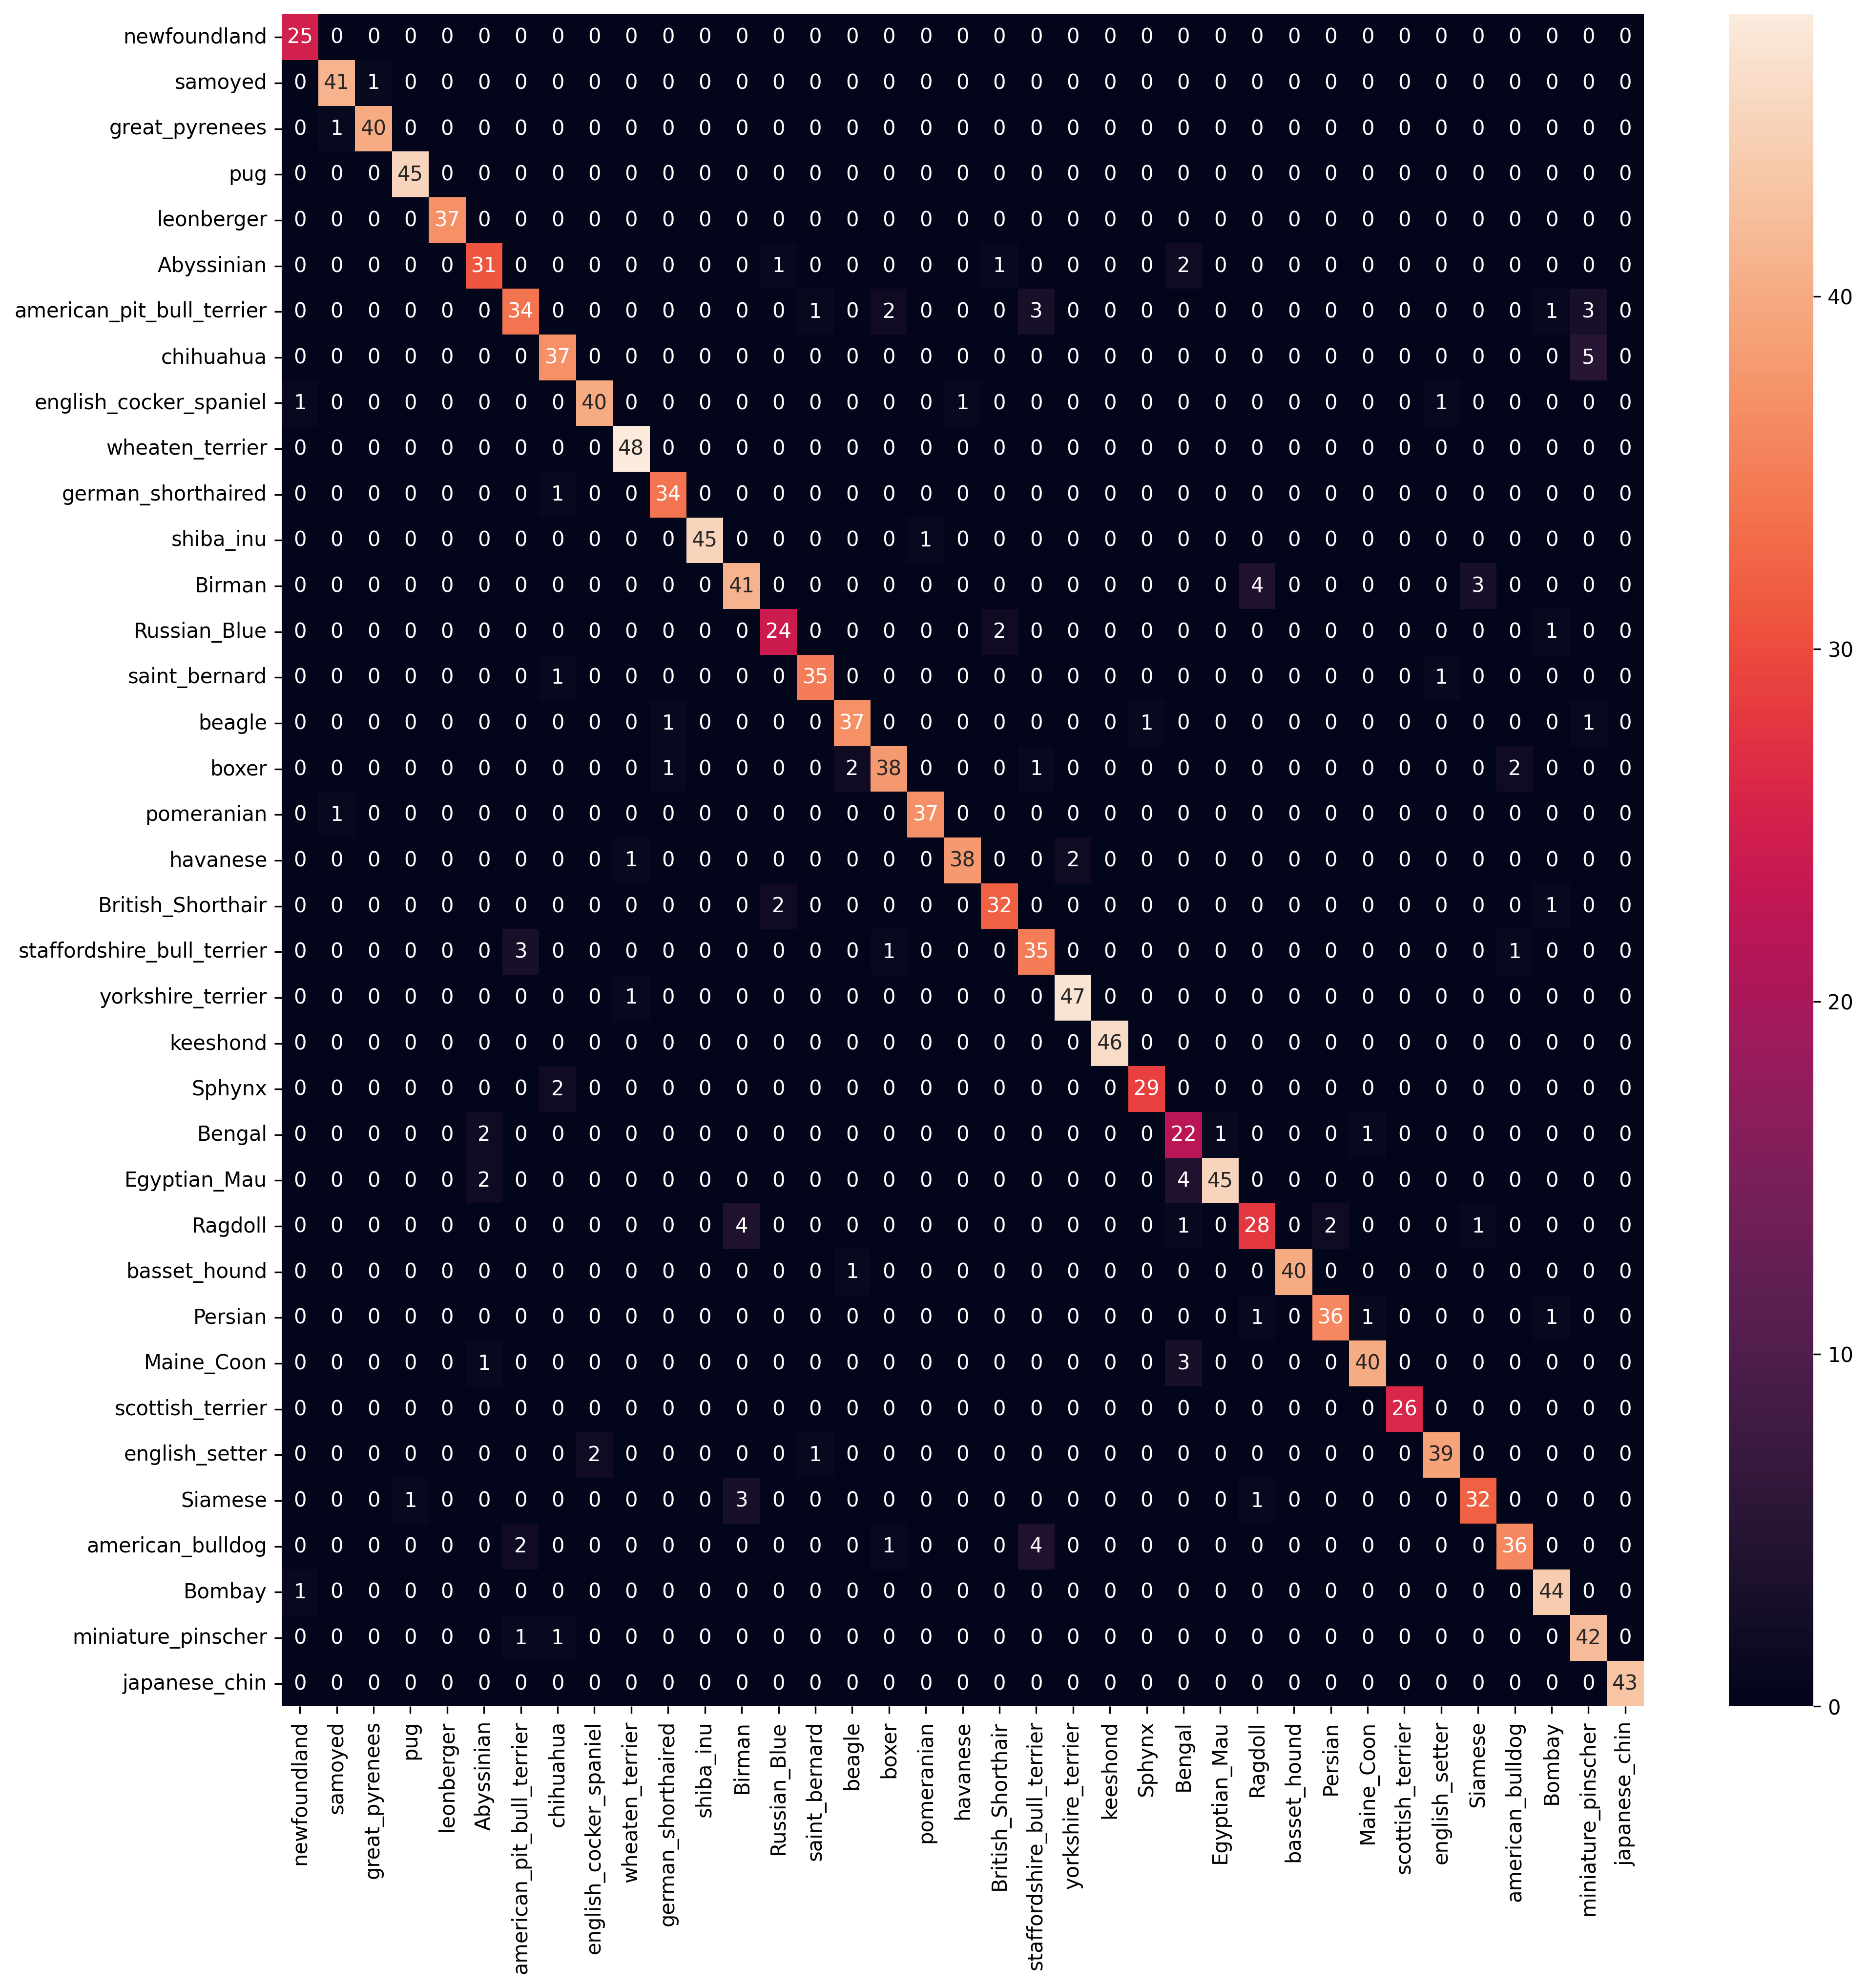

In [27]:
# Implementing confusion matrix for valid dataset
def plot_confusion_matrix(dataloader, model, fig_size = (10,10)):
    with torch.no_grad():
        model.eval()
        model = model.to(device)
        y_preds, y_true = [], []
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device, non_blocking = True), lbls.to(device, non_blocking = True)
            out = model(imgs)
            _, preds = out.max(-1)
            y_preds.extend(preds.cpu().numpy().tolist())
            y_true.extend(lbls.cpu().numpy().tolist())
        conf_mat = confusion_matrix(y_true, y_preds, labels = list(range(len(unique_labels))))
        df_conf_mat = pd.DataFrame(conf_mat, index = unique_labels, columns = unique_labels)
        plt.figure(figsize = fig_size, dpi=300)
        sns.heatmap(df_conf_mat, annot = True)
        plt.show();

model = get_model(dropout_p, freeze = False)
model = load_checkpoint(model)
_, validloader = get_data(img_aug_p, batch_size)
plot_confusion_matrix(validloader, model, fig_size = (15,15))

Using Batchnorm lead to almost 93% accuracy on valid data and 99% accuracy on train data which is far better than using network without batchnorm.